## 主成分分析

### pca from scrach

In [4]:
import pandas as pd
import numpy as np

# サンプルデータ準備
x = np.array([3, 4, 2, 3, 4, 4, 3])
y = np.array([2, 3, 5, 5, 3, 2, 3])

X = pd.DataFrame({'x': x, 'y': y})

In [5]:
def my_pca(X, num_components):
    # 標準化
    X_meaned = X - np.mean(X, axis=0)
    X_scaled = X_meaned / np.std(X_meaned, axis=0)
    
    # 分散共分散行列
    cov_mat = np.cov(X_scaled, rowvar=False)
    
    # 固有ベクトル, 固有値
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_evalues = eigen_values[sorted_index]
    sorted_evectors = eigen_vectors[:, sorted_index]
    subset_evectors = sorted_evectors[:, :num_components]
    
    # 変換
    X_reduced = np.dot(X_scaled, subset_evectors)
    
    return X_reduced

In [6]:
my_pca(X, 1)

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

### pca from sklean

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=1)
pca.fit_transform(X)

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

<AxesSubplot:xlabel='first component', ylabel='second component'>

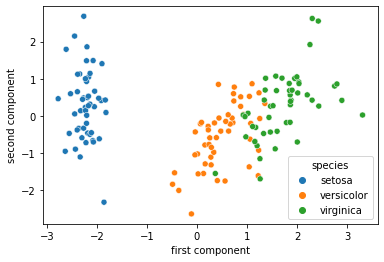

In [8]:
import seaborn as sns

# データ準備
df = sns.load_dataset('iris')
y_col = 'species'
X = df.loc[:, df.columns!=y_col]
y = df[y_col].values

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
X_pc = PCA(n_components=2).fit_transform(X_scaled)

y = y.reshape(-1, 1)
df_pc = pd.DataFrame(np.concatenate([X_pc, y], axis=1), columns=['first component', 'second component', 'species'])

sns.scatterplot(x='first component', y='second component', hue='species', data=df_pc)

In [9]:
df_pc

,first component,second component,species
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa
...,...,...,...
145,1.870503,0.386966,virginica
146,1.56458,-0.896687,virginica
147,1.52117,0.269069,virginica
148,1.372788,1.011254,virginica


 ## 累積寄与率

In [10]:
import matplotlib.pyplot as plt

n_components=4
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [11]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

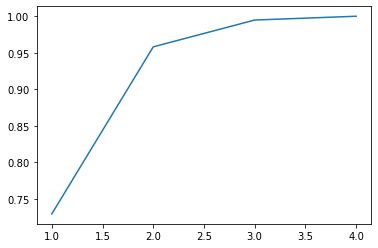

In [12]:
plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_))

## PCAで分類器を作成

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784')

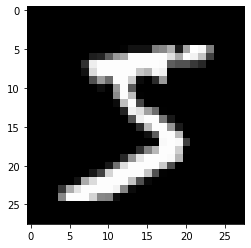

In [13]:
# 画像の再構成
im = mnist.data.iloc[0].values.reshape(28, 28)
plt.imshow(im, 'gray')

In [14]:
# hold out
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.3, random_state=0)

# 標準化
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95).fit(X_train)
pca.fit(X_train)

X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [18]:
# 次元削減前
print(X_train.shape[-1])

# 次元削減後
print(X_train_pc.shape[-1])

784
323


In [22]:
# ロジスティック回帰(PCAあり)
from sklearn.linear_model import LogisticRegression
import time

model_pca = LogisticRegression()
before = time.time()
model_pca.fit(X_train_pc, y_train)
after = time.time()

print(f"fit took {after - before:.2f}s")

fit took 3.29s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
y_pred_pc = model_pca.predict(X_test_pc)

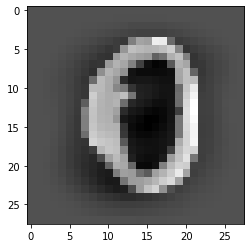

In [30]:
im = X_test[0].reshape(28, 28)
plt.imshow(im, 'gray')

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_pc)

0.9195238095238095

In [32]:
# ロジスティック回帰(PCAなし)
model = LogisticRegression()
before = time.time()
model.fit(X_train, y_train)
after = time.time()

print(f"fit took {after - before:.2f}s")

fit took 8.68s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
